# Neural Network to Classify Handwritten Digits from MNIST Data set

## The Architecture

https://github.com/peterantonarosjr/NeuralNetFromScratch/blob/main/NN_Architecture.pdf

## Implementation

In [51]:
#These are going to be the only 3 imports I am allowing myself to create this network
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
trainData = pd.read_csv("/home/peterjr/RepoCollections/NeuralNetFromScratch/MNIST_Data/train.csv")
testData = pd.read_csv("/home/peterjr/RepoCollections/NeuralNetFromScratch/MNIST_Data/test.csv")

In [53]:
#We need to split training data into X and y
trainData.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
#Taking a look at X_train
X_train = trainData.loc[:, trainData.columns != 'label']
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
#Taking a look at y's
y_train = trainData[['label']]
y_test = testData

In [56]:
#Convert to numpy arrays
X_train = np.array(X_train).T/255
y_train = np.array(y_train).flatten().T
m = X_train.shape[1]
display(m)
display(X_train.shape)
display(y_train.shape)

42000

(784, 42000)

(42000,)

In [57]:
#Testing data
X_test = np.array(testData).T/255
y_test = np.array(y_test).flatten().T
X_test.shape
y_test.shape

(21952000,)

In [58]:
y_train.shape

(42000,)

In [59]:
#Defining functions related to our architecture above

#Set the initial parameters for the network
def initParams():
    #Random weights and bX_trainias between -0.5 and 0.5
    w1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    w2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    return w1,b1,w2,b2

#Define activation layers (& derivatives) for use in forward propagation
def relu(z):
    #Returns 0 if <= 0 otherwise value
    return np.maximum(z,0)

def reluDeriv(z):
    return z>0

#Define a hot encoding 
def hotEncode(y):
    #Create hotY size and fill 0s
    hotY = np.zeros((y.size, y.max() + 1))
    #Encodde
    hotY[np.arange(y.size), y] = 1
    #Transpose
    hotY = hotY.T
    return hotY

def softMax(z):
    exp = np.exp(z - np.max(z))
    return exp / exp.sum(axis=0)

#Define a forward propagation function to move inputs -> network
def forwardProp(w1,b1,w2,b2,X):
    z1 = w1.dot(X) + b1
    A1 = relu(z1)
    z2 = w2.dot(A1) + b2
    A2 = softMax(z2)
    return z1,A1,z2,A2

#Define a backward propagation function to move inputs <- network
def backwardProp(w1,z1,A1,w2,z2,A2,X,y):
    hotY = hotEncode(y)
    dz2 = 2*(A2 - hotY)
    dw2 = 1/m * dz2.dot(A1.T)
    db2 = 1/m * np.sum(dz2,1)    
    
    dz1 = w2.T.dot(dz2) * reluDeriv(z1)
    dw1 = 1/m * dz1.dot(X.T) 
    db1 = 1/m * np.sum(dz1,1)
    return dw1,db1,dw2,db2

#Define a function to update our parameters during main loop
def updateParams(w1,dw1,b1,db1,w2,dw2,b2,db2,alpha):
    w1 = w1 - alpha*dw1
    b1 = b1 - alpha*np.reshape(db1, (10,1))
    w2 = w2 - alpha*dw2
    b2 = b2 - alpha*np.reshape(db2, (10,1))
    return w1,b1,w2,b2

#Define a function to generate predictions with CURRENT weights
def makePredictions(A):
    return np.argmax(A,0)

#Define a function to calculate error with CURRENT weights
def getAccuracy(preds, y):
    #Accuracy = # correct predictions / # total obs
    return np.sum(preds == y)/y.size

#Define a gradient descent as our 'main loop'
def gradDescent(X,y,alpha,iterations,threshold):
    domain = list(range(iterations+1))
    accuracyList = []
    
    w1,b1,w2,b2 = initParams()
    predictions = makePredictions(X)
    
    accuracy = getAccuracy(predictions,y)
    accuracyList.append(accuracy)


    for i in range(iterations):
            
        #Start loop here
        z1,A1,z2,A2 = forwardProp(w1,b1,w2,b2,X)
        dw1,db1,dw2,db2 = backwardProp(w1,z1,A1,w2,z2,A2,X,y)
        w1,b1,w2,b2 = updateParams(w1,dw1,b1,db1,w2,dw2,b2,db2,alpha)
            
        predictions = makePredictions(A2)
        accuracy = getAccuracy(predictions,y)
            
        accuracyList.append(accuracy)

    return w1,b1,w2,b2,domain,accuracyList

In [60]:
#Call on gradDescent() and watch it go!
w1,b1,w2,b2,xVals,yVals = gradDescent(X_train,y_train,0.1,100,.95)

### Training Accuracy Curve

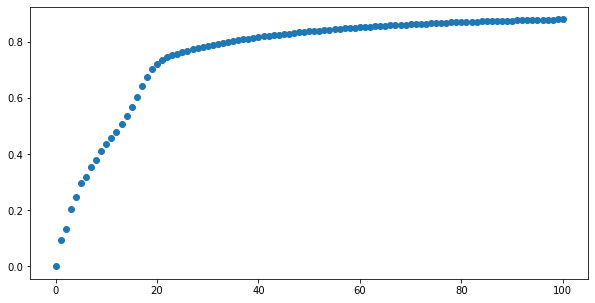

In [61]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.scatter(xVals,yVals)
plt.show()

### Test Set Performance Examples

In [62]:
def predictionTest(X,y,w1,b1,w2,b2):
    #Run forward propagation once with the end training weights
    _,_,_,A2 = forwardProp(w1,b1,w2,b2,X)
    preds = makePredictions(A2)

    return preds

In [63]:
testPreds = predictionTest(X_test,y_test,w1,b1,w2,b2)

In [64]:
def showPrediction(index,X,predictions):
    
    images = X[:, index,None]
    prediction = predictions
    print("Prediction: ", prediction[index])
    print("Image: ")

    current_image = images.reshape((28, 28)) * 255

    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
        

Prediction:  6
Image: 


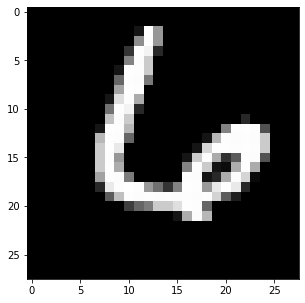

Prediction:  2
Image: 


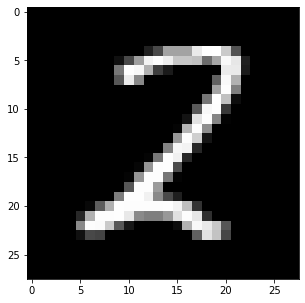

Prediction:  1
Image: 


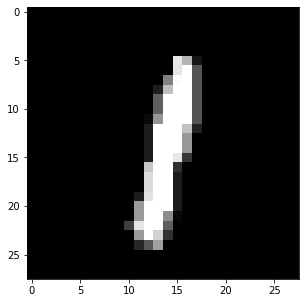

Prediction:  9
Image: 


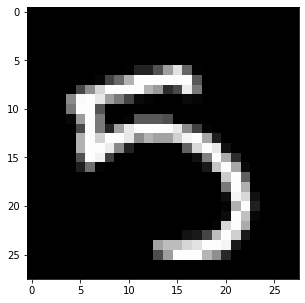

Prediction:  7
Image: 


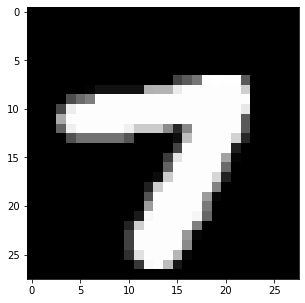

Prediction:  0
Image: 


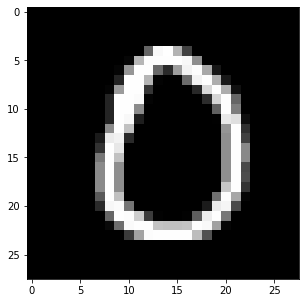

Prediction:  1
Image: 


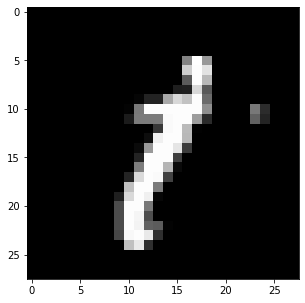

Prediction:  7
Image: 


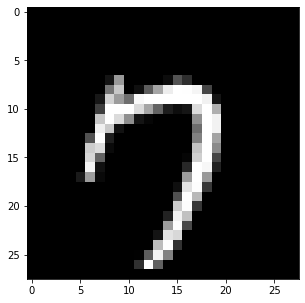

Prediction:  3
Image: 


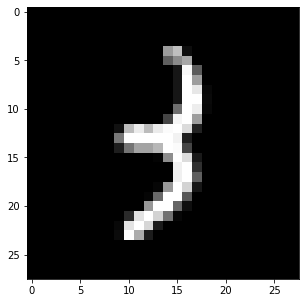

Prediction:  7
Image: 


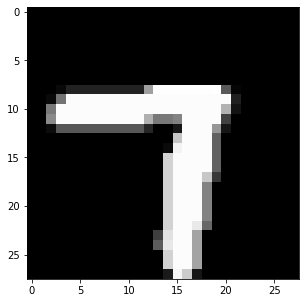

In [65]:
randSamples = np.random.choice(range(X_test.shape[1]), 10, replace=False)

for i in randSamples:
    showPrediction(i,X_test,testPreds)